# Manipulate waveform decomposition frame and find corotating angles

### Setup Environment

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Setup plotting backend
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
from matplotlib.pyplot import *
# Import needed packages from positive
from positive.plotting import sYlm_mollweide_plot
from positive import alert
# Import other usefuls
from os.path import expanduser
from nrutils import scsearch,gwylm
from nrutils.core.basics import *
from numpy import *

(positive)>> Applying custom matplotlib settings.


### Find a simulation

In [2]:

# A = scsearch(institute='bam',keyword='q8a04t60_T_96_360',verbose=True)
A = scsearch(institute='bam',keyword='q4a08t120',verbose=True)

# A = scsearch(institute='bam',keyword='q4a08t30dPm4_T_96_360',verbose=True)

# A = scsearch(institute='gt',keyword='Sq4_d9_a0.6_oth.090_rr_M140',verbose=True)
# A = scsearch(q=1,keyword='hrq',verbose=True)
# A = scsearch(precessing=True,verbose=True)
# A = scsearch(keyword='EP_um2D10_d6_sz-n88')

(scsearch)>> Found institute (=bam) keyword.
(scsearch)>> Found keyword (=q4a08t120) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][hogshead] q4: 1chi0.80-p-q4.00	(q4a08t120dP1_T_96_360)



### Load waveform data

In [3]:
sce = A[0]
# sce.raw_metadata.show()
print sce.L
print sce.S
print sce.J
print sce.S+sce.L

[ 0.35289904  0.          0.55857964]
[-0.138232  0.441773 -0.218798]
[ 0.21466704  0.441773    0.33978164]
[ 0.21466704  0.441773    0.33978164]


In [4]:
y_ = gwylm( A[0], lmax=2, verbose=True, clean=True, calcnews = False, dt=0.5,pad=500,__M_RELATIVE_SIGN_CONVENTION__=-1 )
# y = gwylm( A[0], lm=[(3,3)], clean=False, dt=0.5, verbose=True,pad=500 )

# simdir = '/Users/book/MOUNT/tmp/mnt/hogshead/NR_data/ReducedData-hogshead/q2/q2a04t90dPm1_T_96_408/'
# y = gwylm( simdir, lmax=2, clean=True )

(gwylm)>> Found __M_RELATIVE_SIGN_CONVENTION__ (=-1) keyword.
(gwylm)>> Found clean (=True) keyword.
(gwylm)>> Found dt (=0.5) keyword.
(gwylm)>> Found lmax (=2) keyword.
(gwylm)>> Found pad (=500) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x10dec25a8>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(__init__)>> Using default input M_RELATIVE_SIGN_CONVENTION of -1
(gwylm)>> The (extraction_parameter,level) is (5,7), which differs from the config values of (5,5). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2), (2, -2), (2, -1), (2, 0), (2, 1)]
(load)>> Using the default extraction_parameter of 5
(load)>> Using the default level of 7
(load)>> Loading: psi3col.r5.l7.l2.m2.gz
(straighten_wfarr!)>> The time series has been found to be non-monotonic. We will sort the data to enforce mon

In [5]:
print y_.simdir

/Users/book/MOUNT/tmp/mnt/hogshead/NR_data/ReducedData-hogshead/q4/q4a08t120dP1_T_96_360/


([<matplotlib.axes._subplots.AxesSubplot at 0x1101a7850>,
 <matplotlib.figure.Figure at 0x1101a7790>)

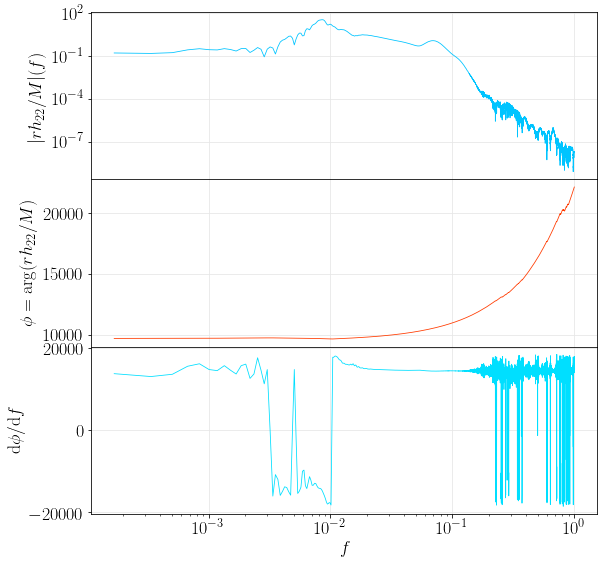

In [6]:
y_.lm[2,2]['strain'].plot(domain='freq')

([<matplotlib.axes._subplots.AxesSubplot at 0x112855110>,
 <matplotlib.figure.Figure at 0x10ebaf5d0>)

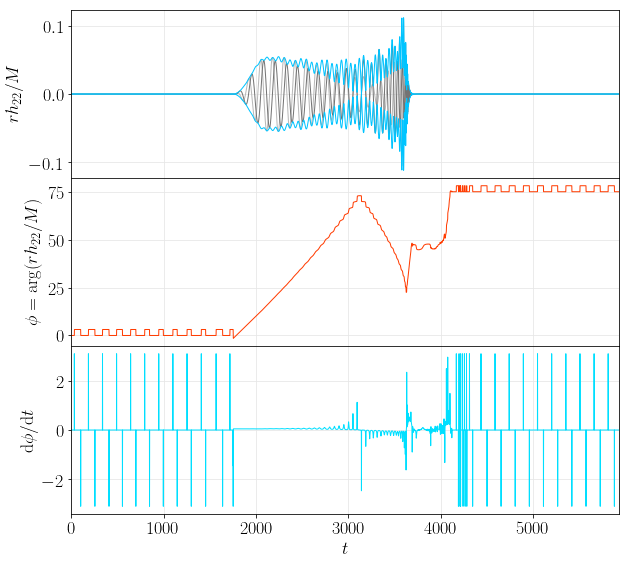

In [7]:
y_.lm[2,2]['strain'].plot(domain='time')

## Inspaect precession dynamics in default simulation frame

### Try to calculate corotating angles

In [8]:
# Perform rotation
y = y_.copy()
# y = y_.__rotate_frame_at_all_times__([0,pi,0])

In [50]:

# Options
kind = 'psi4'
domain = 'time'

# Construct dictionary of multipoles using all multipoles available
mp = { (l,m) : ( y.lm[l,m][kind].y if domain in ('t','time') else y.lm[l,m][kind].fd_y ) for l,m in y.lm  }
mp_strain = { (l,m) : ( y.lm[l,m]['strain'].y if domain in ('t','time') else y.lm[l,m]['strain'].fd_y ) for l,m in y.lm  }
domain_vals = y.lm[2,2][kind].t if domain in ('t','time') else y.lm[2,2][kind].f

# Calculate corotating angles using low-level function
alpha,beta,gamma,x,yy,z = calc_coprecessing_angles( mp, domain_vals, ref_orientation=y.J, return_xyz='all' )
alpha_strain,beta_strain,gamma_strain,x_strain,yy_strain,z_strain = calc_coprecessing_angles( mp_strain, domain_vals, ref_orientation=y.J, return_xyz='all' )


(11874,)
(11874,)


q4a08t120dP1_T_96_360


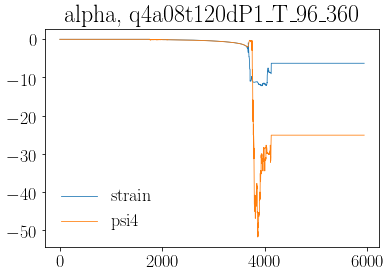

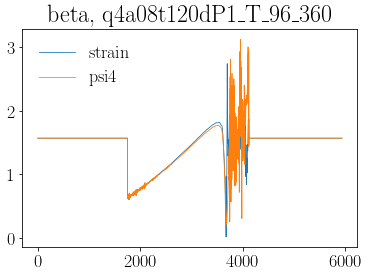

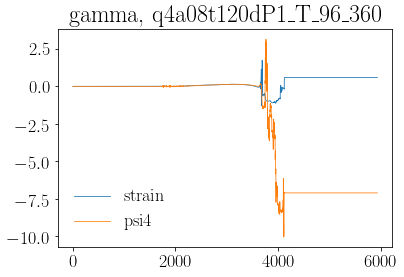

In [51]:

figure()
title(r'alpha, %s'%y_.simname.replace('_','\_'))
plot( domain_vals, alpha_strain, label='strain' )
plot( domain_vals, alpha, label='psi4' )
# xlim( 1300,2900 )
# ylim(-3.2,1)
legend()
# savefig('/Users/book/Desktop/alpha_%s.pdf'%y.simname)


figure()
title(r'beta, %s'%y_.simname.replace('_','\_'))
plot( domain_vals, beta_strain, label='strain' )
plot( domain_vals, beta, label='psi4' )
# xlim( 1300,2900 )
# ylim(0,0.25)
legend()
# savefig('/Users/book/Desktop/beta_%s.pdf'%y.simname)


figure()
title(r'gamma, %s'%y_.simname.replace('_','\_'))
plot( domain_vals, gamma_strain, label='strain' )
plot( domain_vals, gamma, label='psi4' )
# xlim( 1300,2900 )
# ylim(-0.01,2)
legend()
# savefig('/Users/book/Desktop/gamma_%s.pdf'%y.simname)

print y.simname

### Plot the angles and the waveform amplitude for reference

(2145.5, 3721.5)

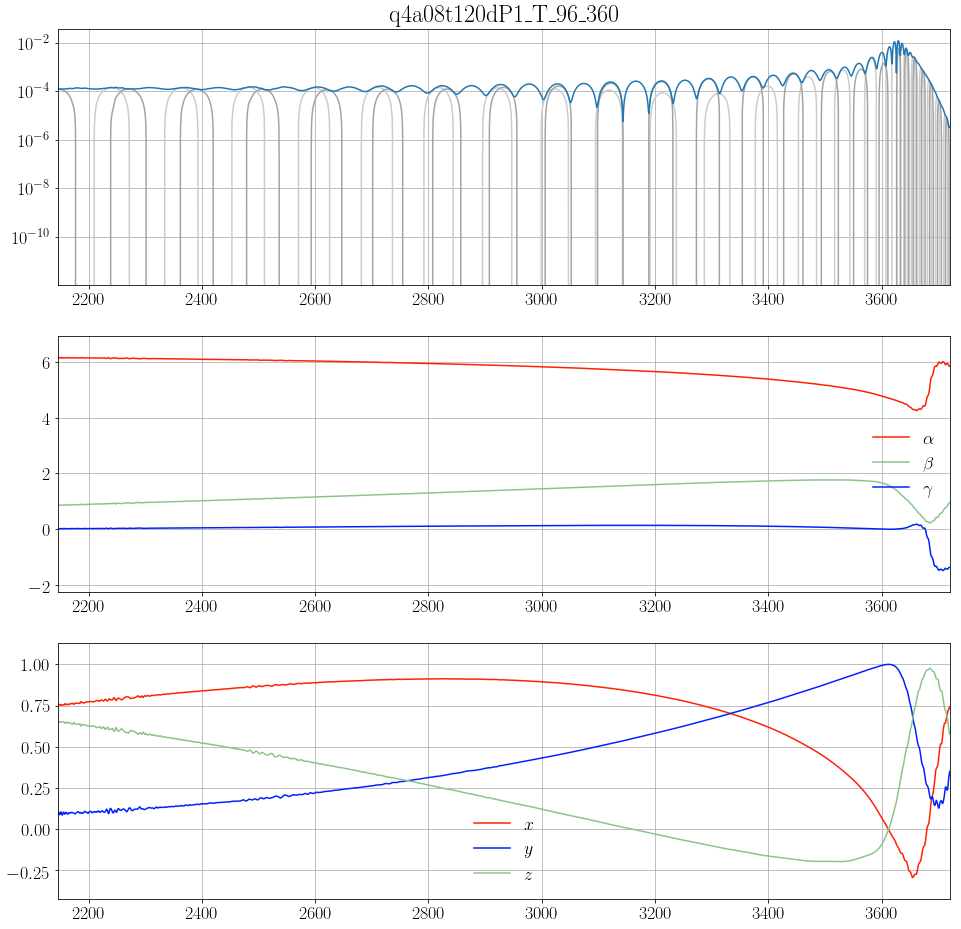

In [53]:

#
fig = figure( figsize=4*figaspect(1) )
clr = rgb(3,jet=True); grey = ones(3)*0.8
lw = 1.5

#
domain_min = domain_vals[y.preinspiral.right_index] if domain in ('t','time') else y.wstart_pn/(2*pi)
domain_max = domain_vals[y.postringdown.left_index] if domain in ('t','time') else y.lm[2,2][kind].dt

#
mask = (domain_vals>=domain_min) & (domain_vals<=domain_max)

#
ax = subplot(3,1,1)
title( y.simname.replace('_','\_') )
if domain in ('t','time'):
    plot( domain_vals, y.lm[2,2][kind].plus, color=grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].cross, color=0.8*grey, linewidth = lw )
    plot( domain_vals, y.lm[2,2][kind].amp, linewidth = lw )
    yscale('log',nonposy='clip')
else:
    plot( domain_vals, y.lm[2,2][kind].fd_amp, linewidth = lw )
    xscale('log'); yscale('log')
    ylim( lim(y.lm[2,2][kind].fd_amp[mask]) )
grid()

#
subplot(3,1,2,sharex=ax)
reshift = lambda V: V - V[mask][0] + mod(V[mask][0],2*pi)
plot( domain_vals, reshift(alpha), color = clr[0], linewidth = lw, label=r'$\alpha$' )
plot( domain_vals, reshift(beta),  color = clr[1], linewidth = lw, label=r'$\beta$' )
plot( domain_vals, reshift(gamma), color = clr[2], linewidth = lw, label=r'$\gamma$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([reshift(alpha)[mask],reshift(beta)[mask],reshift(gamma)[mask]]), dilate=0.1 ) )
grid()

#
subplot(3,1,3,sharex=ax)
plot( domain_vals, reflect_unwrap(x), color = clr[0], linewidth = lw, label=r'$x$' )
plot( domain_vals, yy,  color = clr[2], linewidth = lw, label=r'$y$' )
plot( domain_vals, z, color = clr[1], linewidth = lw, label=r'$z$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([x[mask],yy[mask],z[mask]]), dilate=0.1 ) )
grid()

#
ax.set_xlim( [ domain_min, domain_max ] )
# ax.set_xlim( [ 1600,1650 ] )


### Plot XY Projection of angles in polar coordinates

**  0.672948212925
&&  [ 0.16017115  0.33829824  0.33323753]
&&  [ 0.1507862  0.3263233  0.3255042]
0.359431308728 0.739690066711 0.56891804288


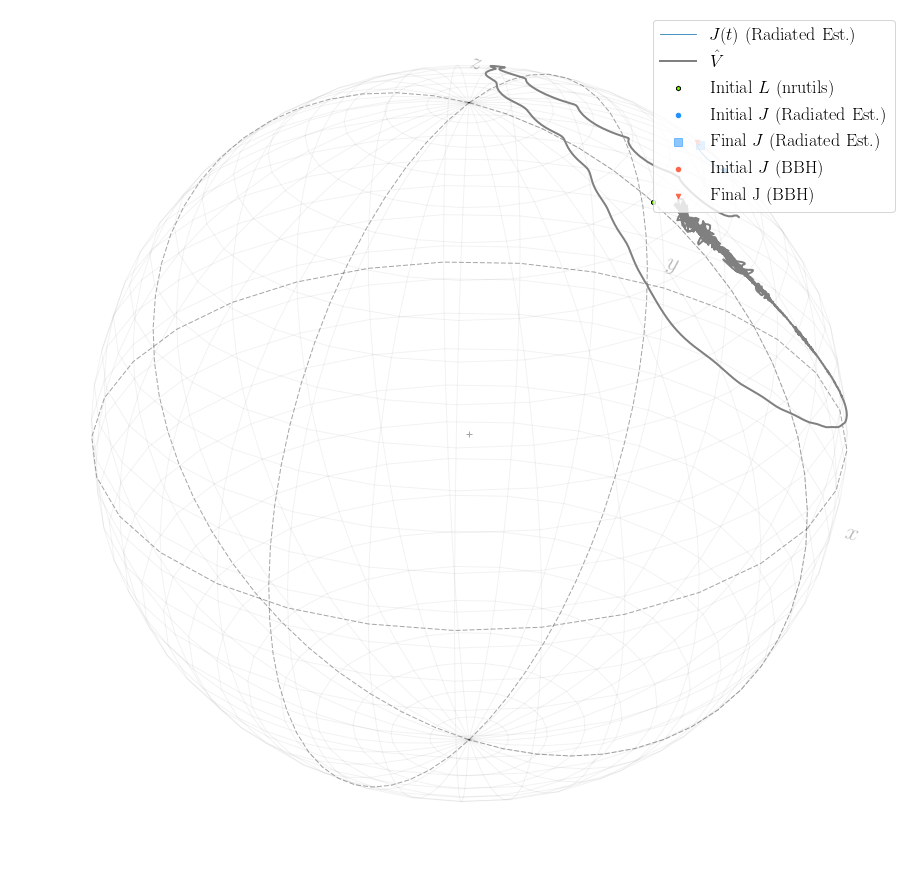

In [55]:
# %matplotlib auto
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import *

#
fig = figure( figsize=4*figaspect(1) )
ax = fig.add_subplot(111, projection='3d')
color = rgb(3)

#
plot_3d_mesh_sphere( ax, color='k', alpha=0.05, lw=1 )

#
y.__calc_radiated_quantities__(use_mask=False)
k = 0
jx,jy,jz = y.remnant['J'][k] / linalg.norm( y.remnant['J'][k] )
jfx,jfy,jfz = y.remnant['J'][-1] / linalg.norm( y.remnant['J'][-1] )

#
# mask = smoothest_part(alpha, smoothness_radius=80, smoothness_stepsize=3, smooth_length=3, smoothness_tolerance=0.5, unsigned=True)
# mask =y.remnant['mask'][1:]
mask = arange( y.startindex+1, y.endindex_by_frequency+1 )

#
# axhline(0,color='k')
# axvline(0,color='k')

#
lx,ly,lz = (y.L1+y.L2)/linalg.norm( y.L1+y.L2 )#
ax.scatter( lx,ly,lz, marker='h', color='lawngreen', label='Initial $L$ (nrutils)',edgecolors='k' )

print '** ',dot([ lx,ly,lz],[jx,jy,jz])

#
ax.scatter( jx,jy,jz,marker='o', c='dodgerblue', label='Initial $J$ (Radiated Est.)' )
ax.scatter( jfx,jfy,jfz,marker='s', c='dodgerblue', label='Final $J$ (Radiated Est.)',s=80,alpha=0.5 )

#
# plot( 0,0, 'xk', alpha=0.5 )

#
J = y.remnant['J']
print '&& ',J[-1]
print '&& ',y.Sf
absJ = zeros_like(J)
for k in range(J.shape[0]):
    J[k] /= linalg.norm(J[k])
    absJ[k] = J[k]
plot( J[:,0],J[:,1],J[:,2], label='$J(t)$ (Radiated Est.)' )

#
S1 = array([ y.raw_metadata.initial_bh_spin2x, y.raw_metadata.initial_bh_spin2y, y.raw_metadata.initial_bh_spin2z])
S2 = array([ y.raw_metadata.initial_bh_spin1x, y.raw_metadata.initial_bh_spin1y, y.raw_metadata.initial_bh_spin1z])
S = S1+S2
L = array([ y.raw_metadata.initial_angular_momentumx, y.raw_metadata.initial_angular_momentumy, y.raw_metadata.initial_angular_momentumz])
bbh_jx,bbh_jy,bbh_jz = (L+S)/linalg.norm( L+S )
ax.scatter( bbh_jx,bbh_jy,bbh_jz, label='Initial $J$ (BBH)', color='tomato', marker='o' )
print bbh_jx,bbh_jy,bbh_jz

#
sfx,sfy,sfz = y.Sf/linalg.norm(y.Sf)
ax.scatter( sfx,sfy,sfz, color='tomato', label='Final J (BBH)', marker='v' )

#
plot( x[mask],yy[mask],z[mask], lw=2, color='grey', label='$\hat{V}$' )


# axis('equal');

#
xlabel('$x$')
ylabel('$y$');

# ax.set_xlim([-1,1])
# ax.set_ylim([-1,1])
# ax.set_zlim([-1,1])

axlim = 0.64*array([-1,1])
ax.set_xlim(axlim)
ax.set_ylim(axlim)
ax.set_zlim(axlim)

axis('off')

#
# ax.view_init(90,270)


#

legend( loc=1, frameon=True )

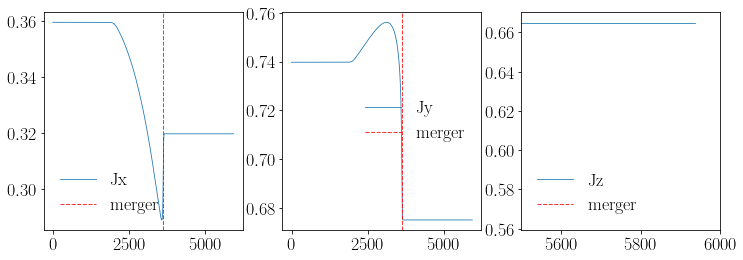

In [56]:
figure(figsize=figaspect(0.33))
subplot(1,3,1)
plot( y.t, y.remnant['J'][:,0], label='Jx' )
axvline( y.t[y[2,2]['psi4'].k_amp_max], color='r', ls='--', label='merger' )
# xlim( [ 5500,6000 ] )
legend()
subplot(1,3,2)
plot( y.t, y.remnant['J'][:,1], label='Jy' )
axvline( y.t[y[2,2]['psi4'].k_amp_max], color='r', ls='--', label='merger' )
# xlim( [ 5500,6000 ] )
legend()
subplot(1,3,3)
plot( y.t, y.remnant['J'][:,2], label='Jz' )
axvline( y.t[y[2,2]['psi4'].k_amp_max], color='r', ls='--', label='merger' )
xlim( [ 5500,6000 ] )
legend()

## Inspect simulation dynamics when J_initial || z; that is, perform rotations to rotate quantities accordingly.

In [14]:

# Calculate the initial J 

# k = 0
# J = y.remnant['J'][k] / linalg.norm( y.remnant['J'][k] )

S1 = array([ y.raw_metadata.initial_bh_spin2x, y.raw_metadata.initial_bh_spin2y, y.raw_metadata.initial_bh_spin2z])
S2 = array([ y.raw_metadata.initial_bh_spin1x, y.raw_metadata.initial_bh_spin1y, y.raw_metadata.initial_bh_spin1z])
S = S1+S2
L = array([ y.raw_metadata.initial_angular_momentumx, y.raw_metadata.initial_angular_momentumy, y.raw_metadata.initial_angular_momentumz])
J = (L+S)/linalg.norm( L+S )

# Calculate angles required to rotate J into z direction
Jx,Jy,Jz = J
# NOTE that the minus signs here signify that we are totating the opposite dirction in which the angles are computed
beta = -arccos( Jz/linalg.norm(J) )
gamma = -arctan2( Jy,Jx )

# Define zeta (i.e. -alpha) such that L is along the y-z plane
L = (y.L1 + y.L2) / linalg.norm(y.L1 + y.L2) 
L_ = rotate3 ( L, 0, beta, gamma )
zeta = arctan2( L_[1], L_[0] )

#
alpha = -zeta

#
angles = [alpha,beta,gamma]

# 
alert( 'Rotating J along the z direction should yield [0,0,1] below:' )
print 'J = ',J
print '  = ',rotate3( J, alpha,beta,gamma)
print 'L = ',L
print '  = ',rotate3( L, alpha,beta,gamma)

#
print '* ', dot(L,J)
print '* ', dot(rotate3( L, alpha,beta,gamma),rotate3( J, alpha,beta,gamma))

#
print 'alpha \t= ',alpha
print 'beta  \t= ',beta
print 'gamma \t= ',gamma

# Perform rotation
g = y.__rotate_frame_at_all_times__(angles)

#
print  (g.L1 + g.L2) / linalg.norm(g.L1 + g.L2) 

(notebook)>> Rotating J along the z direction should yield [0,0,1] below:
J =  [ 0.35943131  0.73969007  0.56891804]
  =  [ -4.31327138e-17  -2.77708745e-18   1.00000000e+00]
L =  [ 0.53411405  0.          0.84541243]
  =  [  7.39690067e-01   3.84555340e-17   6.72947699e-01]
*  0.672947698717
*  0.672947698717
alpha 	=  2.43471555998
beta  	=  -0.965606689772
gamma 	=  -1.11847481583
(__rotate_frame_at_all_times__)>> Note that metadata at the scentry level (i.e. this.__scentry__) have not been rotated, but this.Sf, this.R1 and others have been rotated.
[  7.39690067e-01   2.66465781e-17   6.72947699e-01]


In [15]:
# Options
kind = 'psi4'
domain = 't'

# Construct dictionary of multipoles using all multipoles available
mp = { (l,m) : ( g[l,m][kind].y if domain in ('t','time') else g[l,m][kind].fd_y ) for l,m in y.lm  }
domain_vals = g[2,2][kind].t if domain in ('t','time') else g[2,2][kind].f

#
k = 0
g.__calc_radiated_quantities__()
initial_j = g.remnant['J'][k] / linalg.norm( g.remnant['J'][k] )

# Calculate corotating angles using low-level function
alpha,beta,gamma,x,yy,z = calc_coprecessing_angles( mp, domain_vals, ref_orientation=g.J, return_xyz='all' )

(2145.5, 3721.5)

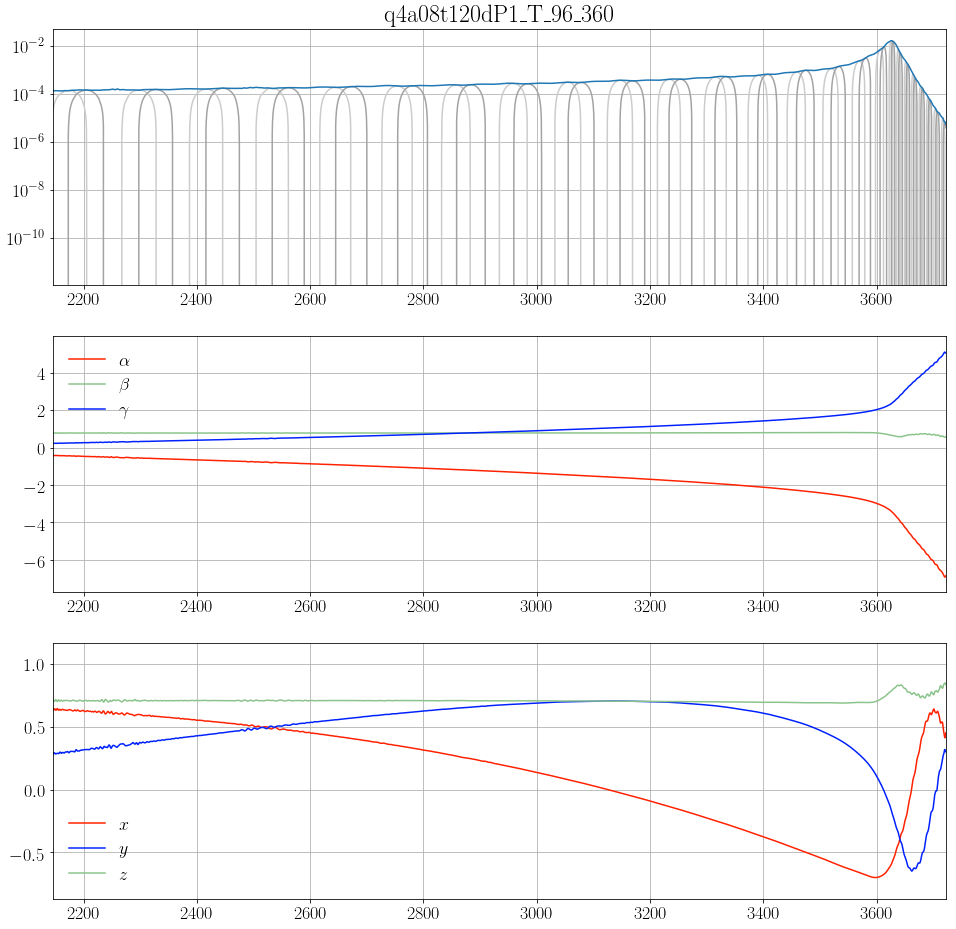

In [16]:

#
fig = figure( figsize=4*figaspect(1) )
clr = rgb(3,jet=True); grey = ones(3)*0.8
lw = 1.5

#
domain_min = domain_vals[y.preinspiral.right_index] if domain in ('t','time') else y.wstart_pn/(2*pi)
domain_max = domain_vals[y.postringdown.left_index] if domain in ('t','time') else y.lm[2,2][kind].dt

#  NOTE that this is defined in gwylm.__calc_radiated_quantities__() and that g.remnant['mask'] == g.radiated['mask']
mask = g.remnant['mask']

#
ax = subplot(3,1,1)
title( g.simname.replace('_','\_') )
if domain in ('t','time'):
    plot( domain_vals, g.lm[2,2][kind].plus, color=grey, linewidth = lw )
    plot( domain_vals, g.lm[2,2][kind].cross, color=0.8*grey, linewidth = lw )
    plot( domain_vals, g.lm[2,2][kind].amp, linewidth = lw )
    yscale('log',nonposy='clip')
else:
    plot( domain_vals, g.lm[2,2][kind].fd_amp, linewidth = lw )
    xscale('log'); yscale('log')
    ylim( lim(g.lm[2,2][kind].fd_amp[mask]) )
grid()

#
subplot(3,1,2,sharex=ax)
reshift = lambda V: V - V[mask][0] + mod(V[mask][0],2*pi)
plot( domain_vals, reshift(alpha), color = clr[0], linewidth = lw, label=r'$\alpha$' )
plot( domain_vals, reshift(beta),  color = clr[1], linewidth = lw, label=r'$\beta$' )
plot( domain_vals, reshift(gamma), color = clr[2], linewidth = lw, label=r'$\gamma$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([reshift(alpha)[mask],reshift(beta)[mask],reshift(gamma)[mask]]), dilate=0.1 ) )
# yscale('log')
grid()

#
subplot(3,1,3,sharex=ax)
plot( domain_vals, x, color = clr[0], linewidth = lw, label=r'$x$' )
plot( domain_vals, yy,  color = clr[2], linewidth = lw, label=r'$y$' )
plot( domain_vals, z, color = clr[1], linewidth = lw, label=r'$z$' )
legend( frameon=False, loc='best' )
ylim( lim( hstack([x[mask],yy[mask],z[mask]]), dilate=0.1 ) )
grid()

#
ax.set_xlim( [ domain_min, domain_max ] )

&&  [ 0.04401105 -0.04257643  0.49739121]
&&  [ 0.04352578 -0.04638009  0.4807606 ]


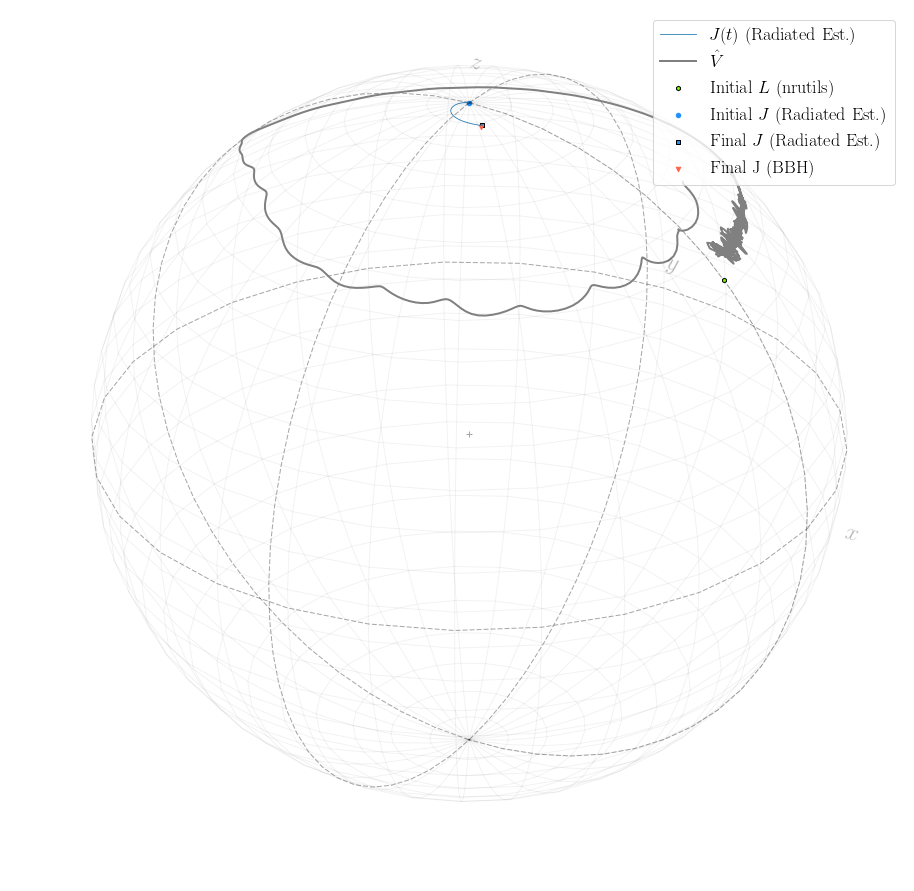

In [17]:
#
# %matplotlib auto
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import *

#
fig = figure( figsize=4*figaspect(1) )
ax = fig.add_subplot(111, projection='3d')
color = rgb(3)

#
plot_3d_mesh_sphere( ax, color='k', alpha=0.05, lw=1 )

#
g.__calc_radiated_quantities__(use_mask=False)
k = 0
jx,jy,jz = g.remnant['J'][k] / linalg.norm( g.remnant['J'][k] )
jfx,jfy,jfz = g.remnant['J'][-1] / linalg.norm( g.remnant['J'][-1] )

#
# mask = smoothest_part(alpha, smoothness_radius=80, smoothness_stepsize=3, smooth_length=3, smoothness_tolerance=0.5, unsigned=True)
# mask = g.remnant['mask'][1:]
mask = arange( g.startindex+1, g.endindex_by_frequency+1 )

#
# axhline(0,color='k')
# axvline(0,color='k')

#
lx,ly,lz = (g.L1+g.L2)/linalg.norm( g.L1+g.L2 )#
ax.scatter( lx,ly,lz, marker='h', color='lawngreen', label='Initial $L$ (nrutils)',edgecolors='k' )

#
ax.scatter( jx,jy,jz,marker='o', c='dodgerblue', label='Initial $J$ (Radiated Est.)' )
ax.scatter( jfx,jfy,jfz,marker='s', c='dodgerblue', label='Final $J$ (Radiated Est.)',edgecolors='k' )

#
# plot( 0,0, 'xk', alpha=0.5 )

#
J = g.remnant['J']
print '&& ',J[-1]
print '&& ',g.Sf
absJ = zeros_like(J)
for k in range(J.shape[0]):
    J[k] /= linalg.norm(J[k])
    absJ[k] = J[k]
plot( J[:,0],J[:,1],J[:,2], label='$J(t)$ (Radiated Est.)' )

#
plot( x[mask],yy[mask],z[mask], lw=2, color='grey', label='$\hat{V}$' )

#
sfx,sfy,sfz = g.Sf/linalg.norm(y.Sf)
ax.scatter( sfx,sfy,sfz, color='tomato', label='Final J (BBH)', marker='v' )


# axis('equal');

#
xlabel('$x$')
ylabel('$y$');

# ax.set_xlim([-1,1])
# ax.set_ylim([-1,1])
# ax.set_zlim([-1,1])

axlim = 0.64*array([-1,1])
ax.set_xlim(axlim)
ax.set_ylim(axlim)
ax.set_zlim(axlim)

axis('off')

#
legend( loc=1, frameon=True )

#
# ax.view_init(90,270)